<a href="https://colab.research.google.com/github/ednavivianasegura/ERAP_Curso_R/blob/main/ERAP_R_Course_ModuloII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Título**:  Manipulación de datos con R  - Módulo II (Manejo de datos desordenados y falta de información )                               
                                          
**Autor(es)**:  Edna Viviana Segura Alvarado - Hans Mauricio Carrillo Hernández

**Fecha**: 2025-06

**Institución**: Universidad de La Rioja    

# ¿Qué son los datos faltantes (Missing Data)?

En R, los valores no disponibles o faltantes se representan con NA (Not Available en inglés) y pueden surgir por múltiples motivos:

- errores de registro
- fallos de instrumentos
- no respuesta en encuestas
- entre otros.

(Little & Rubin, 2002): los autores insisten en que el manejo de datos faltantes debe hacerse cuidadosamente porque puede comprometer la validez del análisis estadístico.

Bibliografía:

  Little, Roderick J. A, and Donald B Rubin. Statistical Analysis with Missing Data. Third edition. vol. 793. Newark: Wiley, 2020. Print.


**¿Cómo afectan los datos faltantes a las operaciones básicas?**

Los valores NA en R representan información que no está disponible o que no pudo ser medida. Su presencia puede tener efectos importantes y silenciosos en cálculos básicos si no se gestionan adecuadamente.

In [54]:
x <- c(5, 8, NA, 10)
mean(x)       # Resultado: NA
sum(x)        # Resultado: NA
sd(x)         # Resultado: NA

[1] NA

[1] NA

[1] NA

**¿Por qué?**
R considera que si hay un NA, no puede estar seguro del resultado total. Prefiere devolver NA como advertencia de que el cálculo está incompleto.
Por lo tanto, existe el atributo que nos ayuda con esto:

```
na.rm=TRUE
```





In [55]:
mean(x, na.rm = TRUE)  # Resultado: 7.666...
sum(x, na.rm = TRUE)   # Resultado: 23
sd(x, na.rm = TRUE)    # Resultado: Desviación estándar de los valores observados

[1] 7.666667

[1] 23

[1] 2.516611

**Funciones lógicas y filtros**
Las expresiones lógicas que involucran NA también pueden dar resultados inesperados:

In [56]:
x <- c(1, 2, NA, 4)
x > 2

[1] FALSE FALSE    NA  TRUE

Si luego ejecutamos la siguiente línea

In [57]:
x[x > 2]



[1] NA  4

Funciones agregadas por grupo **(aggregate, group_by + summarise)**

En dplyr, ocurre lo mismo:

In [58]:
library(dplyr)

df <- data.frame(grupo = c("A", "A", "B", "B"), valor = c(10, NA, 5, 8))

df %>%
  group_by(grupo) %>%
  summarise(media = mean(valor))  # Resultado: NA para grupo A (el que contiene NAs)

df %>%
  group_by(grupo) %>%
  summarise(media = mean(valor, na.rm = TRUE))  # Ignora los NA correctamente


grupo,media
<chr>,<dbl>
A,NA
B,6.5


grupo,media
<chr>,<dbl>
A,10.0
B,6.5


**Modelado estadístico (regresiones, clustering, PCA...)**

Los modelos no se ajustan correctamente, o no representan la veracidad si no se gestionan los NA:

,x,y
,<dbl>,<dbl>
1,44.39524,280.0442
2,47.69823,313.1211
3,65.58708,423.3557
4,50.70508,325.4125
5,51.29288,321.9843
6,67.15065,435.9389


       x               y        
 Min.   :26.91   Min.   :175.7  
 1st Qu.:45.33   1st Qu.:294.0  
 Median :50.71   Median :328.9  
 Mean   :51.03   Mean   :329.6  
 3rd Qu.:57.80   3rd Qu.:366.4  
 Max.   :71.87   Max.   :474.4  
 NA's   :15                     

x  y 
15  0


Call:
lm(formula = y ~ x, data = datos)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.505  -7.482  -0.851   6.275  40.020 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.0486     6.7772   0.155    0.877    
x             6.4453     0.1307  49.307   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11 on 83 degrees of freedom
  (15 observations deleted due to missingness)
Multiple R-squared:  0.967,	Adjusted R-squared:  0.9666 
F-statistic:  2431 on 1 and 83 DF,  p-value: < 2.2e-16


[1] 100

[1] 85


Call:
lm(formula = y ~ x, data = datos_imputados)

Residuals:
     Min       1Q   Median       3Q      Max 
-105.702   -8.280   -0.612    7.721  118.220 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.6507    15.2899   0.043    0.966    
x             6.4453     0.2956  21.804   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 24.89 on 98 degrees of freedom
Multiple R-squared:  0.8291,	Adjusted R-squared:  0.8273 
F-statistic: 475.4 on 1 and 98 DF,  p-value: < 2.2e-16


[1] 100

[1] 100

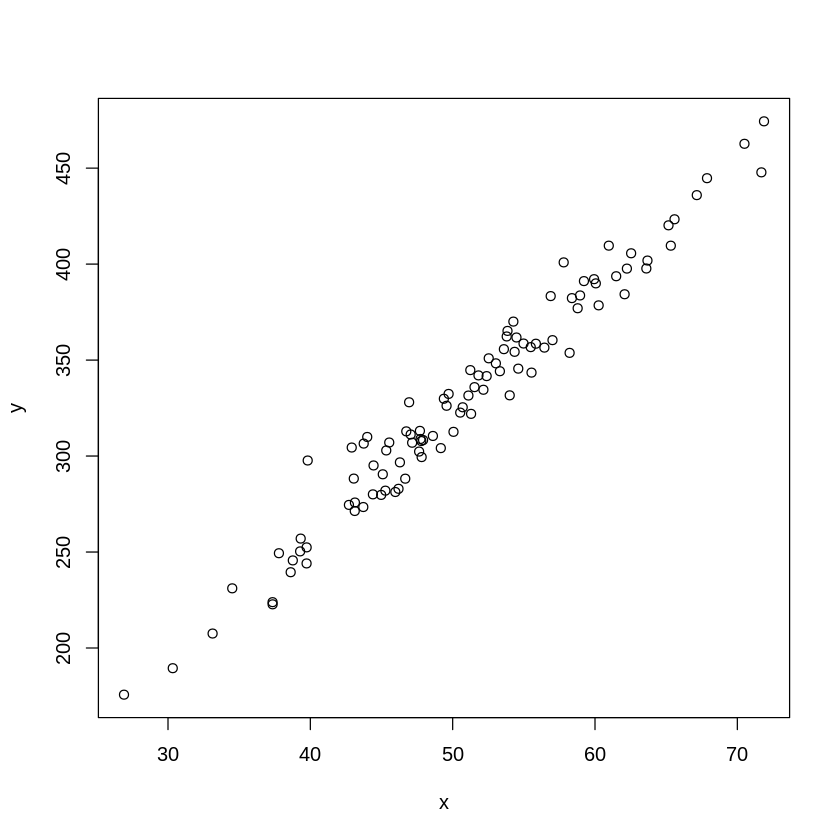

In [59]:
set.seed(123)  # Para reproducibilidad

# Generar 100 observaciones
n <- 100
x <- rnorm(n, mean = 50, sd = 10)          # Variable predictora
y <- 6.5 * x + rnorm(n, mean = 0, sd = 12) # Variable respuesta con ruido

plot(x,y)

datos <- data.frame(x = x, y = y)
head(datos)

# Introducir NA aleatoriamente en 15 valores de x
na_indices <- sample(1:n, size = 15)
datos$x[na_indices] <- NA

summary(datos)
colSums(is.na(datos))

#Intentamos ajustar el modelo
modelo_con_na <- lm(y ~ x, data = datos)
summary(modelo_con_na)

#R ajusta el modelo usando solo las filas donde y no es NA (complete-case analysis).

#Comprobémoslo:
nrow(datos)                # 100 observaciones originales
nrow(modelo_con_na$model)  # Solo 85 filas usadas (15 con NA en x)

#Miremos que pasa con el modelo al imputar, por ejemplo con la media
datos_imputados <- datos
datos_imputados$x[is.na(datos_imputados$x)] <- mean(datos$x, na.rm = TRUE)

modelo_imputado <- lm(y ~ x, data = datos_imputados)
summary(modelo_imputado)

nrow(datos_imputados)                # 100 observaciones originales
nrow(modelo_imputado$model)  # Solo 85 filas usadas (15 con NA en x)




## Detección y diagnóstico de valores faltantes

**¿por qué es tan crítico?**
Un solo NA sin tratar puede hacer que todo un análisis falle o se distorsione.

Los datos faltantes deben ser detectados, visualizados y tratados adecuadamente.

El primer paso siempre debe ser saber si alguna(s) de la(s) variables(s) contiene datos faltantes, para esto contamos con muchas herramientas, veremos algunas de ellas:

In [60]:
#install.packages("naniar")
## Instalar paquetes de visualización de datos faltantes
#install.packages("visdat")
#install.packages("VIM")
## Instalar paquete en desarrollo de estimación de datos faltantes
#install.packages("remotes")
#remotes::install_github("davidbiol/empire")

library(naniar)
library(VIM)

Métodos para detectar NAs.

In [61]:
print("----- Para ver si hay NA --------")

summary(datos)

print("---- Número total de NA ---------")

sum(is.na(datos))

print("----- Número de NA por columna --------")

colSums(is.na(datos))

print("---- Número de NA por fila ---------")

rowSums(is.na(datos))

print("--- Devuelve TRUE si hay al menos un NA en el data.frame. Es la forma más rápida y directa. ----------")

anyNA(datos)

print("---- Devuelve una matriz lógica del mismo tamaño que datos, indicando con TRUE dónde hay NA. ---------")

is.na(datos)

print("---- Devuelve un vector lógico que indica qué filas no tienen ningún NA. Puedes usarlo para filtrar: ---------")

complete.cases(datos)

print("---- Muestra número y porcentaje de NA por fila ---------")

miss_case_summary(datos)







[1] "----- Para ver si hay NA --------"


       x               y        
 Min.   :26.91   Min.   :175.7  
 1st Qu.:45.33   1st Qu.:294.0  
 Median :50.71   Median :328.9  
 Mean   :51.03   Mean   :329.6  
 3rd Qu.:57.80   3rd Qu.:366.4  
 Max.   :71.87   Max.   :474.4  
 NA's   :15                     

[1] "---- Número total de NA ---------"


[1] 15

[1] "----- Número de NA por columna --------"


x  y 
15  0

[1] "---- Número de NA por fila ---------"


[1] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1
 [38] 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0

[1] "--- Devuelve TRUE si hay al menos un NA en el data.frame. Es la forma más rápida y directa. ----------"


[1] TRUE

[1] "---- Devuelve una matriz lógica del mismo tamaño que datos, indicando con TRUE dónde hay NA. ---------"


x,y
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
FALSE,FALSE
TRUE,FALSE
FALSE,FALSE


[1] "---- Devuelve un vector lógico que indica qué filas no tienen ningún NA. Puedes usarlo para filtrar: ---------"


[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE
 [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE
 [25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE
 [37] FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE
 [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
 [73] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE
 [97]  TRUE  TRUE  TRUE  TRUE

[1] "---- Muestra número y porcentaje de NA por fila ---------"


case,n_miss,pct_miss
<int>,<int>,<dbl>
9,1,50
22,1,50
23,1,50
31,1,50
36,1,50
37,1,50
39,1,50
41,1,50
43,1,50


Métodos de visualización:

[1] " -------   Muestra número y porcentaje de NA por variable. -------------"


variable,n_miss,pct_miss
<chr>,<int>,<num>
valor,1,25
grupo,0,0


[1] "---- Muestra un gráfico de barras con la cantidad de valores faltantes por variable y patrones comunes. ---------"


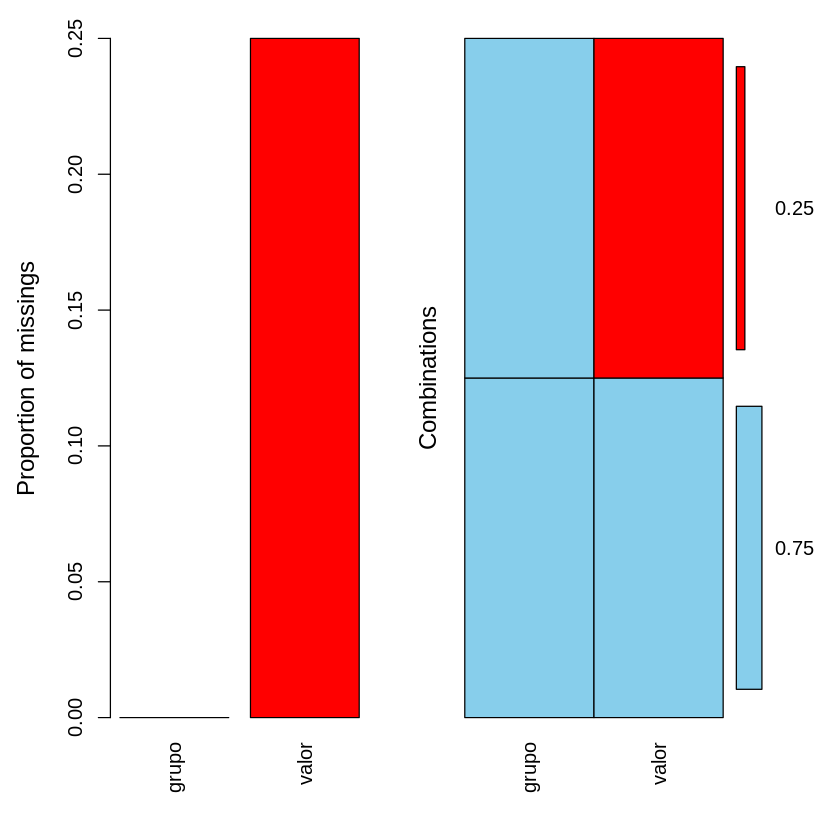

In [85]:
print(" -------   Muestra número y porcentaje de NA por variable. -------------")

miss_var_summary(df)

print("---- Muestra un gráfico de barras con la cantidad de valores faltantes por variable y patrones comunes. ---------")

aggr(df, numbers=TRUE)

## Patrones de pérdida de datos

Los patrones describen *dónde* faltan los datos en el dataset. Los principales son:

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/datossinNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>


- **Univariado**: solo una variable tiene NA:

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/UnivariadoNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>

Solo una variable contiene valores faltantes; el resto de las variables están completamente observadas.
Suele ser el patrón más simple y fácil de manejar.

En este ejemplo vemos la variable Clase tiene valores faltantes. Generalmente es la variable dependiente la que tiene valores faltantes. Probablemente puede presentarse que la persona que clasificó por largo, ancho y forma, olvidó o pasó por alto clasificar esas dos.

- **Multivariado (general)**:

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/MultivariadoNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>


Varias variables contienen valores faltantes, sin seguir un orden estructurado. Es el patrón más común en la práctica.

Por ejemplo en un estudio poblacional, la edad, peso y ingresos tienen valores faltantes, pero distribuidos de forma irregular.

Suele representar más dificultad en la aplicación de algunos métodos clásicos (como imputación monótona).

Vemos en el ejemplo que, si se pierde en una variable, también se pierde en otra para el mismo inidviduo. Es decir, no es aleatorio, tiene un patrón, lo que es muy frecuente en las encuestas.

- **Monótono**: si hay NA en una variable, también en todas las siguientes.

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/MonotonoNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>

Hay un orden específico:
si una observación tiene un valor faltante en la variable Xj, entonces tendrá faltantes en todas las variables posteriores (Xj+1, Xj+2, ...).
Suele observarse en estudios longitudinales, estudios que se realizan a través del tiempo, es decir, podemos verlo como una acumulación de la pérdida de información.

Habitualmente, este patrón permite el uso de métodos de imputación secuenciales como regresión por pasos.

- **Arbitrario**: los valores faltantes aparecen en cualquier lugar, sin estructura visible ni lógica aparente. Es el caso más difícil de manejar y el más común. Son datos díficiles de manejar. Podemos pensarlo como que la probabilidad de que cada variable tenga un dato faltante, sea la misma para todas las variables.

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/GeneraNA.png?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>



Este patrón suele requerir de métodos de imputación más robustos, como imputación múltiple o modelos bayesianos.


### Mecanismos de pérdida de datos

Mientras que los patrones de pérdida describen dónde faltan los datos, los mecanismos de pérdida explican por qué faltan. Esta distinción es central en el enfoque de Little & Rubin (2002) y define si los métodos de tratamiento serán válidos o introducirán sesgos.

Se clasifican en tres tipos principales:

1. MCAR — Missing Completely At Random (pérdida completamente al azar)

La probabilidad de que un dato esté ausente es completamente aleatoria y no depende de ninguna variable observada ni no observada.

Por ejemplo:
Un sensor de temperatura falla esporádicamente debido a una interferencia eléctrica aleatoria.
El fallo no depende ni del valor real ni de ninguna otra variable.

Qué consecuencias puede traer este tipo de mecanismo:

- Es el caso más benigno.
- El análisis en los datos completos no introduce sesgo.
- Se pueden eliminar filas sin problema (listwise deletion, la veremos más adelante).
- Es poco frecuente en la práctica.

2. MAR — Missing At Random (pérdida al azar)

La probabilidad de que un dato falte depende de otras variables observadas, pero no del valor faltante en sí mismo.

Por ejemplo:
Los individuos con más dinero tienden a no reportar su nivel de ingreso.
→ El ingreso falta, pero depende de una variable observada (por ejemplo el estrato, cuyo valor si se tiene).

Qué consecuencias puede traer este tipo de mecanismo:

- Más realista y frecuente.
- El sesgo se puede corregir si incluimos las variables relacionadas en el modelo de imputación (como edad en este ejemplo).
- Métodos como imputación múltiple, regresión, o modelos con pesos son válidos.

3. MNAR — Missing Not At Random (Pérdida no al azar)

La probabilidad de que falte un dato depende del valor faltante en sí mismo.

Por ejemplo:
Personas con altos ingresos se niegan a declarar su salario por privacidad.
→ El dato falta precisamente porque es alto (digamos que también se naron a responder la pregunta relacionada con el estrato socioeconómico, por lo que estaría faltando, pero sabríamos porqué).
En resumen, este mecanismo de pérdida de información depende tanto de los datos observados como de los no observados (de los perdidos)

Qué consecuencias puede traer este tipo de mecanismo:

- Este es el caso más problemático.
- No se puede resolver solo con los datos disponibles.
- Se necesitan suposiciones fuertes, modelos de sensibilidad o diseño adicional (como encuestas complementarias).





### Ejemplo práctico:

<center>
 <img src="https://github.com/ednavivianasegura/AccesoImages/blob/main/collage-mamiferos-cabecera.jpg?raw=true" alt="descriptiva" width="50%" height="50%">  
</center>

Veamos esto de una manera práctica con el dataset `sleep`. Este conjunto se basa en una recopilación de datos de sueño en mamíferos que apareció en el estudio R. M. Siegel (2005). Clues to the functions of mammalian sleep. Nature, 437(7063), 1264–1271. Cada fila representa una especie de mamífero. Y las variables describen: características biológicas (peso corporal, peso cerebral), comportamientos relacionados con el sueño (horas REM y no REM), estrategias de supervivencia (depredador, exposición al peligro) y riesgos ecológicos.

| Variable   | Tipo                | Descripción breve                                        |
| ---------- | ------------------- | -------------------------------------------------------- |
| `BodyWgt`  | numérico            | Peso corporal en kilogramos                              |
| `BrainWgt` | numérico            | Peso del cerebro en gramos                               |
| `NonD`     | numérico            | Horas de sueño no REM (sin movimientos oculares rápidos) |
| `Dream`    | numérico            | Horas de sueño REM (con sueños)                          |
| `Sleep`    | numérico            | Total de horas de sueño por día                          |
| `Span`     | numérico            | Esperanza de vida en años                                |
| `Gest`     | numérico            | Duración de la gestación en días                         |
| `Pred`     | categórica (factor) | ¿Es el animal un depredador? (categoría: sí/no)          |
| `Exp`      | categórica (factor) | ¿Está expuesto a peligro? (bajo, medio, alto)            |
| `Danger`   | numérico            | Nivel de peligro general (valor numérico del riesgo)     |



In [167]:
data(sleep)
# Ver dimensiones del dataset
dim(sleep)
 #Ver variables del dataset
str(sleep)

[1] 62 10

'data.frame':	62 obs. of  10 variables:
 $ BodyWgt : num  6654 1 3.38 0.92 2547 ...
 $ BrainWgt: num  5712 6.6 44.5 5.7 4603 ...
 $ NonD    : num  NA 6.3 NA NA 2.1 9.1 15.8 5.2 10.9 8.3 ...
 $ Dream   : num  NA 2 NA NA 1.8 0.7 3.9 1 3.6 1.4 ...
 $ Sleep   : num  3.3 8.3 12.5 16.5 3.9 9.8 19.7 6.2 14.5 9.7 ...
 $ Span    : num  38.6 4.5 14 NA 69 27 19 30.4 28 50 ...
 $ Gest    : num  645 42 60 25 624 180 35 392 63 230 ...
 $ Pred    : int  3 3 1 5 3 4 1 4 1 1 ...
 $ Exp     : int  5 1 1 2 5 4 1 5 2 1 ...
 $ Danger  : int  3 3 1 3 4 4 1 4 1 1 ...


In [169]:
data(sleep, package = "VIM")
View(sleep)

BodyWgt,BrainWgt,NonD,Dream,Sleep,Span,Gest,Pred,Exp,Danger
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
6654.000,5712.0,NA,NA,3.3,38.6,645,3,5,3
1.000,6.6,6.3,2.0,8.3,4.5,42,3,1,3
3.385,44.5,NA,NA,12.5,14.0,60,1,1,1
0.920,5.7,NA,NA,16.5,NA,25,5,2,3
2547.000,4603.0,2.1,1.8,3.9,69.0,624,3,5,4
10.550,179.5,9.1,0.7,9.8,27.0,180,4,4,4
0.023,0.3,15.8,3.9,19.7,19.0,35,1,1,1
160.000,169.0,5.2,1.0,6.2,30.4,392,4,5,4
3.300,25.6,10.9,3.6,14.5,28.0,63,1,2,1


Hacemos primero un análisis descriptivo

In [68]:
summary(sleep)

    BodyWgt            BrainWgt            NonD            Dream      
 Min.   :   0.005   Min.   :   0.14   Min.   : 2.100   Min.   :0.000  
 1st Qu.:   0.600   1st Qu.:   4.25   1st Qu.: 6.250   1st Qu.:0.900  
 Median :   3.342   Median :  17.25   Median : 8.350   Median :1.800  
 Mean   : 198.790   Mean   : 283.13   Mean   : 8.673   Mean   :1.972  
 3rd Qu.:  48.203   3rd Qu.: 166.00   3rd Qu.:11.000   3rd Qu.:2.550  
 Max.   :6654.000   Max.   :5712.00   Max.   :17.900   Max.   :6.600  
                                      NA's   :14       NA's   :12     
     Sleep            Span              Gest             Pred      
 Min.   : 2.60   Min.   :  2.000   Min.   : 12.00   Min.   :1.000  
 1st Qu.: 8.05   1st Qu.:  6.625   1st Qu.: 35.75   1st Qu.:2.000  
 Median :10.45   Median : 15.100   Median : 79.00   Median :3.000  
 Mean   :10.53   Mean   : 19.878   Mean   :142.35   Mean   :2.871  
 3rd Qu.:13.20   3rd Qu.: 27.750   3rd Qu.:207.50   3rd Qu.:4.000  
 Max.   :19.90   Max.   

Dentro del análisis inicial, es importante revisar la correlación entre las variables

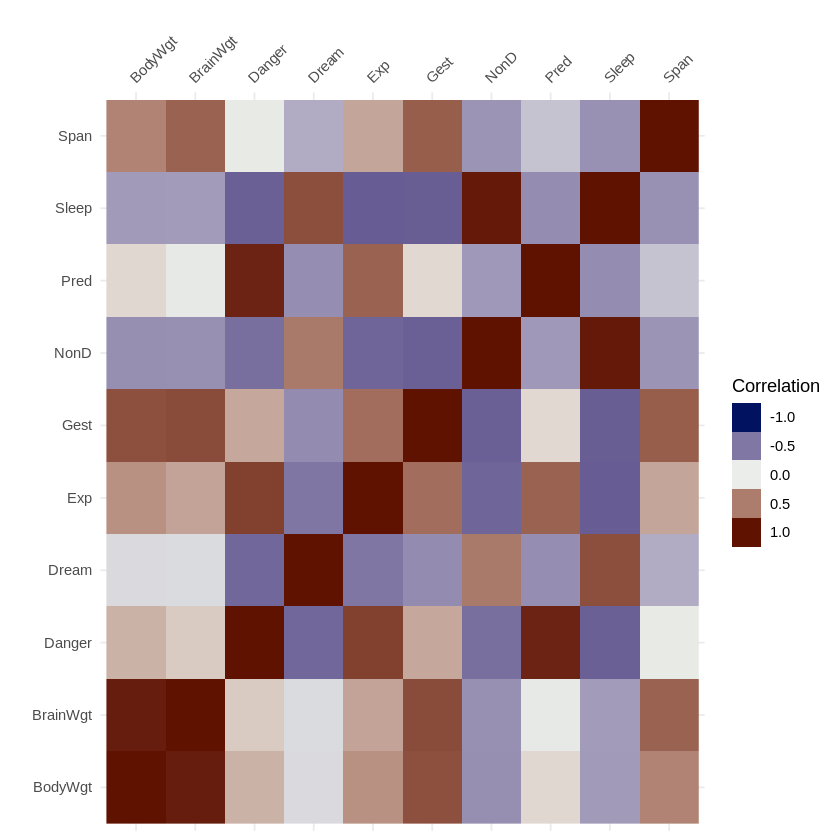

In [69]:
#Correlación (usa una función del paquete visdat para visualizar gráficamente una matriz de correlación entre las variables del dataset sleep:)
visdat::vis_cor(sleep, na_action = "complete.obs")
#El operador :: se utiliza para acceder a una función específica dentro de un paquete, sin necesidad de cargar todo el paquete con library().
#na_action = "complete.obs", indica cómo manejar los valores faltantes (NA) al calcular las correlaciones,
# significa que sólo se usan aquellas filas (observaciones) que no tienen ningún NA en ninguna de las variables consideradas.



Si existe algún tipo de correlación, nos facilita la tarea de estimar los datos faltantes de alguna manera más precisa.

A continuación visualizamos los datos faltantes:

In [73]:
?VIM::aggr

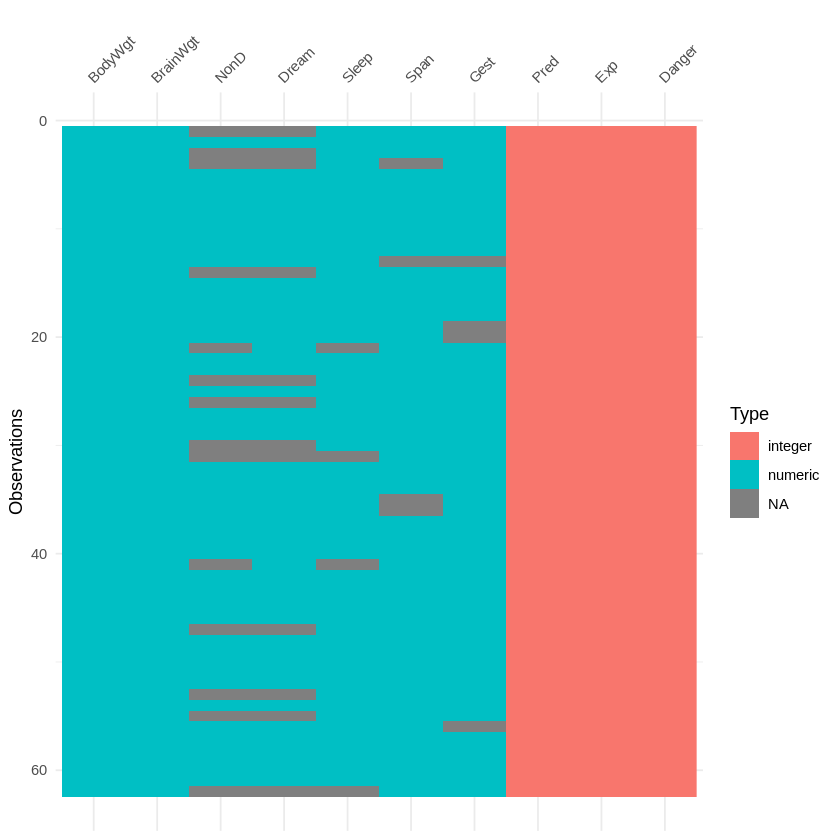

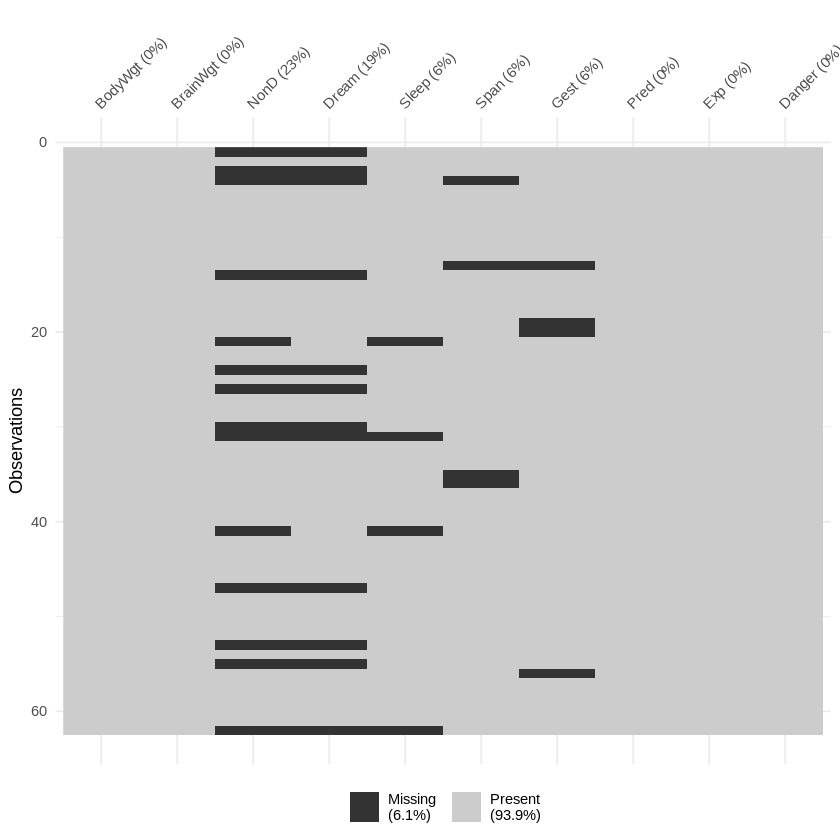


 Variables sorted by number of missings: 
 Variable      Count
     NonD 0.22580645
    Dream 0.19354839
    Sleep 0.06451613
     Span 0.06451613
     Gest 0.06451613
  BodyWgt 0.00000000
 BrainWgt 0.00000000
     Pred 0.00000000
      Exp 0.00000000
   Danger 0.00000000


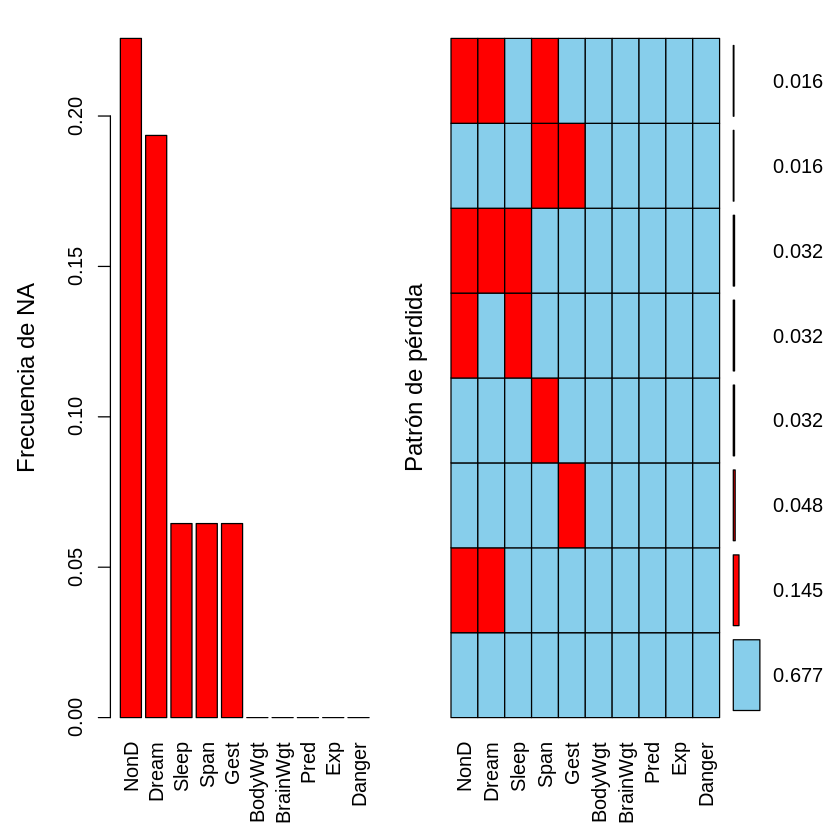

In [82]:
# Visualizar patrón general

#Gráficas
visdat::vis_dat(sleep, sort_type = FALSE)
#¿Qué hace?
# Genera un mapa visual del dataset, donde:
# Cada fila representa una observación.
# Cada columna representa una variable.
# Los colores indican el tipo de dato (numérico, carácter, lógico, NA, etc.).
# Argumento:
# sort_type = FALSE: mantiene el orden original de las variables.
# (Si fuera TRUE, ordenaría las columnas por tipo de dato.)
# ¿Para qué sirve?
# Ver de forma rápida qué variables tienen NA y de qué tipo son las demás.
# Identificar valores atípicos o inconsistencias de tipo (por ejemplo, una columna que debería ser numérica pero es carácter).


visdat::vis_miss(sleep)
#Este nos ayuda a identificar los patrones:
# A qué patrón parece?
# Vemos que cuando se pierde NonD, se pierde también Dream, si comprobamos
# la correlación, vemos que no es tan alta.
# Puede que sea una simple casualidad.

VIM::aggr(sleep, numbers = TRUE, sortVars = TRUE, gap = 3,prop = TRUE,
     ylab = c("Frecuencia de NA", "Patrón de pérdida"))


#Produce una visualización compuesta que incluye:
# Un histograma con el porcentaje de valores faltantes por variable (izquierda).
# Una matriz de combinaciones de ausencia/presencia entre variables (derecha).
# Argumentos clave:
#numbers = TRUE: muestra los valores numéricos sobre las barras.
#sortVars = TRUE: ordena las variables de mayor a menor porcentaje de NA.
#gap = 3: espacio entre los gráficos izquierdo y derecho.
#prop = TRUE: muestra proporciones en lugar de conteo absoluto.
#ylab: etiquetas personalizadas del eje y.
#¿Para qué sirve?
#Diagnóstico visual completo del patrón de pérdida de datos
# Permite ver cómo esta la proporción de pérdida en cada una de las variables.
#Permite detectar si hay correlaciones entre variables faltantes (por ejemplo, cuando dos columnas tienden a estar ausentes juntas).

# También útil: matriz de patrones
#VIM::matrixplot(sleep, sortby = 2)




¿Qué podemos ver aquí?

Gráfico aggr() — Frecuencia y patrón de pérdida
Este gráfico tiene dos componentes:

- A la izquierda: barras verticales rojas
Representan el porcentaje de valores faltantes por variable.

De acuerdo con la tabla y el gráfico de barras:

| Variable | % NA   | Significado                                               |
|----------|--------|------------------------------------------------------------|
| NonD     | 22.6%  | Horas de sueño no REM faltantes en 22.6%                   |
| Dream    | 19.4%  | Horas de sueño REM faltantes en 19.4%                      |
| Sleep    | 6.5%   | Total de horas de sueño faltantes                          |
| Span     | 6.5%   | Esperanza de vida faltante                                 |
| Gest     | 6.5%   | Días de gestación faltantes                                |
| Resto    | 0%     | Completas: sin valores faltantes                           |


Vemos entonces que el mayor problema está en las variables NonD y Dream.

- A la derecha: matriz de patrones de NA
Cada columna representa una variable.

Cada fila representa una combinación específica de presencia/ausencia de datos en una observación.

Rojo = valor faltante | Azul = valor presente

¿Qué observamos?

Hay una gran cantidad de combinaciones diferentes de valores faltantes, lo que sugiere un patrón de pérdida general (arbitrario), no monótono.

Concretamente:

- Fila completamente azul con valor 0,67, indica que todas las variables están presentes (sin NA).
Es decir, ese patrón representa las observaciones completas o casos completos: Valor 0,67: significa que el 67% de las observaciones del dataset están completas, es decir, no tienen ningún valor faltante en ninguna variable.
Por lo tanto, en el dataset sleep con 62 observaciones, esto corresponde a aproximadamente 42 observaciones completas (62*0,67)

- Algunas observaciones tienen múltiples NA; otras tienen uno solo, por ejemplo:

Fila con rojo solo en Gest y valor 0,048, representa el patrón en el que solo falta la variable Gest, el resto de variables está presente. El valor 0,048: implica que el 4.8% de las observaciones tienen NA únicamente en Gest (0,048*65 aprox 3 observaciones).



In [83]:
#Información de número de datos faltantes totales y de la posición
empire::count_miss(data = sleep) #Número de datos faltantes
empire::pos_miss(data = sleep) #Posición fila-columna de los datos faltantes

[1] 38

,Row,Col
,<int>,<dbl>
1,1,3
2,3,3
3,4,3
4,14,3
5,21,3
6,24,3
7,26,3
8,30,3
9,31,3


## Técnicas de manejo de datos faltantes.

| Estrategia                     | Descripción breve                              | Requiere suposiciones fuertes     | Mantiene tamaño de muestra |
| ------------------------------ | ---------------------------------------------- | --------------------------------- | -------------------------- |
| Eliminación de casos           | Omitir filas con NA                            | ❌ Solo válida si MCAR (resultados un poco decentes)             | ❌  (producir sesgos)                        |
| Imputación con media/mediana   | Reemplaza NA por un valor fijo                 | ✅ Simplista, distorsiona varianza | ✅                          |
| Imputación por regresión       | Predice el NA con otras variables observadas   | ✅ Supone relación lineal          | ✅                          |
| Imputación con penalización    | Como la regresión, pero con regularización     | ✅ Menos riesgo de sobreajuste     | ✅                          |
| Imputación múltiple / avanzada | Genera varios datasets imputados + combinación | ✅ Compleja, pero más rigurosa     | ✅                          |


### Eliminación de casos
Es fácil y sin sesgo si los datos faltan al azar.
Puede eliminar mucha información.


In [105]:
# Eliminar filas con cualquier NA

View(sleep)
print(dim(sleep_limpio))

sleep_limpio <- sleep[complete.cases(sleep), ]
print(dim(sleep_limpio))

sleep_limpio2<- sleep %>%
  filter(if_all(everything(), ~ !is.na(.)))
print(dim(sleep_limpio2))

# Ver resumen del nuevo dataset
summary(sleep_limpio)
View(sleep_limpio) #ver los elementos eliminados

# Ver cuántas filas se eliminaron (cantidad y proporción)
cat("\nSe han eliminado", nrow(sleep) - nrow(sleep_limpio),"observaciones, que equivalen aproximadamente al",round((abs(nrow(sleep) - nrow(sleep_limpio))/nrow(sleep)*100),2),"% de la información total")



BodyWgt,BrainWgt,NonD,Dream,Sleep,Span,Gest,Pred,Exp,Danger
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
6654.000,5712.0,NA,NA,3.3,38.6,645,3,5,3
1.000,6.6,6.3,2.0,8.3,4.5,42,3,1,3
3.385,44.5,NA,NA,12.5,14.0,60,1,1,1
0.920,5.7,NA,NA,16.5,NA,25,5,2,3
2547.000,4603.0,2.1,1.8,3.9,69.0,624,3,5,4
10.550,179.5,9.1,0.7,9.8,27.0,180,4,4,4
0.023,0.3,15.8,3.9,19.7,19.0,35,1,1,1
160.000,169.0,5.2,1.0,6.2,30.4,392,4,5,4
3.300,25.6,10.9,3.6,14.5,28.0,63,1,2,1


[1] 42 10
[1] 42 10
[1] 42 10


    BodyWgt             BrainWgt            NonD            Dream      
 Min.   :   0.0050   Min.   :   0.14   Min.   : 2.100   Min.   :0.000  
 1st Qu.:   0.3162   1st Qu.:   3.60   1st Qu.: 6.150   1st Qu.:0.900  
 Median :   2.2500   Median :  12.20   Median : 8.500   Median :1.650  
 Mean   : 100.8139   Mean   : 218.68   Mean   : 8.743   Mean   :1.900  
 3rd Qu.:  10.4125   3rd Qu.: 155.50   3rd Qu.:11.000   3rd Qu.:2.375  
 Max.   :2547.0000   Max.   :4603.00   Max.   :17.900   Max.   :6.600  
     Sleep            Span             Gest            Pred      
 Min.   : 2.90   Min.   :  2.00   Min.   : 12.0   Min.   :1.000  
 1st Qu.: 8.05   1st Qu.:  5.25   1st Qu.: 32.0   1st Qu.:2.000  
 Median : 9.80   Median : 11.20   Median : 90.0   Median :3.000  
 Mean   :10.64   Mean   : 19.37   Mean   :129.9   Mean   :2.952  
 3rd Qu.:13.60   3rd Qu.: 27.00   3rd Qu.:195.0   3rd Qu.:4.000  
 Max.   :19.90   Max.   :100.00   Max.   :624.0   Max.   :5.000  
      Exp            Danger    
 M

,BodyWgt,BrainWgt,NonD,Dream,Sleep,Span,Gest,Pred,Exp,Danger
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
2,1.000,6.60,6.3,2.0,8.3,4.5,42.0,3,1,3
5,2547.000,4603.00,2.1,1.8,3.9,69.0,624.0,3,5,4
6,10.550,179.50,9.1,0.7,9.8,27.0,180.0,4,4,4
7,0.023,0.30,15.8,3.9,19.7,19.0,35.0,1,1,1
8,160.000,169.00,5.2,1.0,6.2,30.4,392.0,4,5,4
9,3.300,25.60,10.9,3.6,14.5,28.0,63.0,1,2,1
10,52.160,440.00,8.3,1.4,9.7,50.0,230.0,1,1,1
11,0.425,6.40,11.0,1.5,12.5,7.0,112.0,5,4,4
12,465.000,423.00,3.2,0.7,3.9,30.0,281.0,5,5,5



Se han eliminado 20 observaciones, que equivalen aproximadamente al 32.26 % de la información total

### Imputación con la media

- Sustiye el dato faltante por el valor medio de la variable, calculado con los datos existentes.
- Es especialmente válida cuando los datos faltantes siguen un patrón MCAR, cuando la correlación entre las variables es baja y el porcentaje de datos faltantes es bajo.
- Afecta la potencia de la prueba.
- Afecta la distribución de las variables.
- No tiene en cuenta las demás variables.

In [166]:
#defino función para calcular sd a todas las variables numércias:
st_total<- function(x)
    {if(is.numeric(x)) resultado <- sd(x, na.rm = TRUE) else resultado <-NA
    return (resultado)}

print("Vista de datos originales")
View(sleep) #los nuevos datos

# Imputación con la media
new_sleep_mean <- empire::impute_mean(data = sleep)
#tiene varios atributos (vario s objetos)

#new_sleep_mean$positions #muestra las posiciones de los valores faltantes
#new_sleep_mean$imp_values #cuales son los valores imputados
print("Vista de datos nuevos")
View(new_sleep_mean$new_data) #los nuevos datos

# Revisar variables
# Comparación de datasets (medias, cuartiles y desvest)

print("Resumen datos normales")
summary(sleep)
sapply(sleep,st_total)



print("Resumen datos imputados con la media")
summary(new_sleep_mean$new_data)
sapply(new_sleep$new_data, st_total)




[1] "Vista de datos originales"


BodyWgt,BrainWgt,NonD,Dream,Sleep,Span,Gest,Pred,Exp,Danger
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
6654.000,5712.0,NA,NA,3.3,38.6,645,3,5,3
1.000,6.6,6.3,2.0,8.3,4.5,42,3,1,3
3.385,44.5,NA,NA,12.5,14.0,60,1,1,1
0.920,5.7,NA,NA,16.5,NA,25,5,2,3
2547.000,4603.0,2.1,1.8,3.9,69.0,624,3,5,4
10.550,179.5,9.1,0.7,9.8,27.0,180,4,4,4
0.023,0.3,15.8,3.9,19.7,19.0,35,1,1,1
160.000,169.0,5.2,1.0,6.2,30.4,392,4,5,4
3.300,25.6,10.9,3.6,14.5,28.0,63,1,2,1


[1] "Vista de datos nuevos"


BodyWgt,BrainWgt,NonD,Dream,Sleep,Span,Gest,Pred,Exp,Danger
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
6654.000,5712.0,8.672917,1.972,3.30000,38.60000,645.0000,3,5,3
1.000,6.6,6.300000,2.000,8.30000,4.50000,42.0000,3,1,3
3.385,44.5,8.672917,1.972,12.50000,14.00000,60.0000,1,1,1
0.920,5.7,8.672917,1.972,16.50000,19.87759,25.0000,5,2,3
2547.000,4603.0,2.100000,1.800,3.90000,69.00000,624.0000,3,5,4
10.550,179.5,9.100000,0.700,9.80000,27.00000,180.0000,4,4,4
0.023,0.3,15.800000,3.900,19.70000,19.00000,35.0000,1,1,1
160.000,169.0,5.200000,1.000,6.20000,30.40000,392.0000,4,5,4
3.300,25.6,10.900000,3.600,14.50000,28.00000,63.0000,1,2,1


[1] "Resumen datos normales"


    BodyWgt            BrainWgt            NonD            Dream      
 Min.   :   0.005   Min.   :   0.14   Min.   : 2.100   Min.   :0.000  
 1st Qu.:   0.600   1st Qu.:   4.25   1st Qu.: 6.250   1st Qu.:0.900  
 Median :   3.342   Median :  17.25   Median : 8.350   Median :1.800  
 Mean   : 198.790   Mean   : 283.13   Mean   : 8.673   Mean   :1.972  
 3rd Qu.:  48.203   3rd Qu.: 166.00   3rd Qu.:11.000   3rd Qu.:2.550  
 Max.   :6654.000   Max.   :5712.00   Max.   :17.900   Max.   :6.600  
                                      NA's   :14       NA's   :12     
     Sleep            Span              Gest             Pred      
 Min.   : 2.60   Min.   :  2.000   Min.   : 12.00   Min.   :1.000  
 1st Qu.: 8.05   1st Qu.:  6.625   1st Qu.: 35.75   1st Qu.:2.000  
 Median :10.45   Median : 15.100   Median : 79.00   Median :3.000  
 Mean   :10.53   Mean   : 19.878   Mean   :142.35   Mean   :2.871  
 3rd Qu.:13.20   3rd Qu.: 27.750   3rd Qu.:207.50   3rd Qu.:4.000  
 Max.   :19.90   Max.   

BodyWgt   BrainWgt       NonD      Dream      Sleep       Span       Gest 
899.158011 930.278942   3.666452   1.442651   4.606760  18.206255 146.805039 
      Pred        Exp     Danger 
  1.476414   1.604792   1.441252

[1] "Resumen datos imputados con la media"


    BodyWgt            BrainWgt            NonD            Dream      
 Min.   :   0.005   Min.   :   0.14   Min.   : 2.100   Min.   :0.000  
 1st Qu.:   0.600   1st Qu.:   4.25   1st Qu.: 6.800   1st Qu.:1.050  
 Median :   3.342   Median :  17.25   Median : 8.673   Median :1.972  
 Mean   : 198.790   Mean   : 283.13   Mean   : 8.673   Mean   :1.972  
 3rd Qu.:  48.203   3rd Qu.: 166.00   3rd Qu.:10.550   3rd Qu.:2.275  
 Max.   :6654.000   Max.   :5712.00   Max.   :17.900   Max.   :6.600  
     Sleep             Span             Gest            Pred      
 Min.   : 2.600   Min.   :  2.00   Min.   : 12.0   Min.   :1.000  
 1st Qu.: 8.225   1st Qu.:  7.00   1st Qu.: 39.0   1st Qu.:2.000  
 Median :10.533   Median : 16.65   Median :106.0   Median :3.000  
 Mean   :10.533   Mean   : 19.88   Mean   :142.4   Mean   :2.871  
 3rd Qu.:13.150   3rd Qu.: 27.00   3rd Qu.:195.0   3rd Qu.:4.000  
 Max.   :19.900   Max.   :100.00   Max.   :645.0   Max.   :5.000  
      Exp            Danger     
 

BodyWgt   BrainWgt       NonD      Dream      Sleep       Span       Gest 
899.158011 930.278942   3.647043   1.385763   4.619321  17.716976 144.029998

### Imputación con la mediana

- Sustiye el dato faltante por la mediana de la variable, calculado con los datos existentes.
- Es especialmente válida cuando los datos faltantes siguen un patrón MCAR, cuando la correlación entre las variables es baja y el porcentaje de datos faltantes es bajo.
- Es mejor que la media, en datos no paramétricos, mientras que si los datos son paramétricos es mejor la media que la mediana.
- Afecta la distribución de la variable (tanto media como mediana)
- No tiene en cuenta las demás variables.

In [147]:
#Imputación con la mediana
new_sleep_mediana <- empire::impute_median(data = sleep)

#new_sleep_mediana$imp_values
#new_sleep_mediana$new_data


# Revisar variables
# Comparación de datasets (medias, cuartiles y desvest)

print("Resumen datos normales")
summary(sleep)
sapply(sleep,st_total)

print("Resumen datos imputados con la media")
summary(new_sleep_mediana$new_data)
sapply(new_sleep_mediana$new_data, st_total)


[1] "Resumen datos normales"


    BodyWgt            BrainWgt            NonD            Dream      
 Min.   :   0.005   Min.   :   0.14   Min.   : 2.100   Min.   :0.000  
 1st Qu.:   0.600   1st Qu.:   4.25   1st Qu.: 6.250   1st Qu.:0.900  
 Median :   3.342   Median :  17.25   Median : 8.350   Median :1.800  
 Mean   : 198.790   Mean   : 283.13   Mean   : 8.673   Mean   :1.972  
 3rd Qu.:  48.203   3rd Qu.: 166.00   3rd Qu.:11.000   3rd Qu.:2.550  
 Max.   :6654.000   Max.   :5712.00   Max.   :17.900   Max.   :6.600  
                                      NA's   :14       NA's   :12     
     Sleep            Span              Gest             Pred      
 Min.   : 2.60   Min.   :  2.000   Min.   : 12.00   Min.   :1.000  
 1st Qu.: 8.05   1st Qu.:  6.625   1st Qu.: 35.75   1st Qu.:2.000  
 Median :10.45   Median : 15.100   Median : 79.00   Median :3.000  
 Mean   :10.53   Mean   : 19.878   Mean   :142.35   Mean   :2.871  
 3rd Qu.:13.20   3rd Qu.: 27.750   3rd Qu.:207.50   3rd Qu.:4.000  
 Max.   :19.90   Max.   

BodyWgt   BrainWgt       NonD      Dream      Sleep       Span       Gest 
899.158011 930.278942   3.666452   1.442651   4.606760  18.206255 146.805039 
      Pred        Exp     Danger 
  1.476414   1.604792   1.441252

[1] "Resumen datos imputados con la media"


    BodyWgt            BrainWgt            NonD           Dream      
 Min.   :   0.005   Min.   :   0.14   Min.   : 2.10   Min.   :0.000  
 1st Qu.:   0.600   1st Qu.:   4.25   1st Qu.: 6.80   1st Qu.:1.050  
 Median :   3.342   Median :  17.25   Median : 8.35   Median :1.800  
 Mean   : 198.790   Mean   : 283.13   Mean   : 8.60   Mean   :1.939  
 3rd Qu.:  48.203   3rd Qu.: 166.00   3rd Qu.:10.55   3rd Qu.:2.275  
 Max.   :6654.000   Max.   :5712.00   Max.   :17.90   Max.   :6.600  
     Sleep             Span             Gest            Pred      
 Min.   : 2.600   Min.   :  2.00   Min.   : 12.0   Min.   :1.000  
 1st Qu.: 8.225   1st Qu.:  7.00   1st Qu.: 39.0   1st Qu.:2.000  
 Median :10.450   Median : 15.10   Median : 79.0   Median :3.000  
 Mean   :10.527   Mean   : 19.57   Mean   :138.3   Mean   :2.871  
 3rd Qu.:13.150   3rd Qu.: 27.00   3rd Qu.:195.0   3rd Qu.:4.000  
 Max.   :19.900   Max.   :100.00   Max.   :645.0   Max.   :5.000  
      Exp            Danger     
 Min.   

BodyWgt   BrainWgt       NonD      Dream      Sleep       Span       Gest 
899.158011 930.278942   3.221203   1.294801   4.453205  17.638943 142.775007 
      Pred        Exp     Danger 
  1.476414   1.604792   1.441252

Ahora veremos técnicas más avanzadas, más cercanas a la realidad (mejores estimación):

### Estimación por regresión lineal múltiple

- La imputación del dato faltante en la variable de interés depende de otras variables.
- Reemplaza cada dato faltante por un valor estimado basado en un modelo de regresión con las variables existentes.
- La técnica es relativamente efectiva cuando las correlaciones de las variables son estables, es decir, no varían mucho con un dato más o un dato menos (si tenemos un tamaño muestral relativamente grande).
- Si se cumplen los supuestos de una regresión múltiple, homocedasticidad, linealidad, etc, estqa técnica es muy muy buena.
- Esta técninca evita alterar significativamente las desviaciones estándar o en general, la forma de la distribución.

(volver al ejemplo de patrón univariado (imagne arriba))


In [128]:
cor(sleep[, 1:7], use = "pairwise.complete.obs")



,BodyWgt,BrainWgt,NonD,Dream,Sleep,Span,Gest
BodyWgt,1.0000000,0.9341638,-0.3759462,-0.1093833,-0.3071859,0.3024506,0.6511022
BrainWgt,0.9341638,1.0000000,-0.3692177,-0.1051388,-0.3581020,0.5092527,0.7472425
NonD,-0.3759462,-0.3692177,1.0000000,0.5142539,0.9627147,-0.3844318,-0.5947028
Dream,-0.1093833,-0.1051388,0.5142539,1.0000000,0.7270870,-0.2957453,-0.4508987
Sleep,-0.3071859,-0.3581020,0.9627147,0.7270870,1.0000000,-0.4102024,-0.6313262
Span,0.3024506,0.5092527,-0.3844318,-0.2957453,-0.4102024,1.0000000,0.6148488
Gest,0.6511022,0.7472425,-0.5947028,-0.4508987,-0.6313262,0.6148488,1.0000000


In [135]:
# Estimación por regresión lineal múltiple
# Solo seleccionamos variables numéricas para imputar por regresión

empire::estimate_mlr(data = sleep[,1:7])
# En el momento de aplicar la regresión lineal múltiple, los parámetros se estiman calculando X*transpuesta de X y luego se calcula la inversa.
# Lo que pasa es que en algún momento del cálculo debe estar dando "indefinido" al hacer este cálculo.
# Este problema, con la estimación lineal múltiple, sucede cuando se viola alguno de los supuestos, en este caso, lo más probable es que se esté
# violando el supuesto de multicolinealidad


ERROR: Error in solve.default(XtX): system is computationally singular: reciprocal condition number = 8.28061e-21


In [136]:
#En este caso, sólo con fines de mostrar los resultados, escogemos variables que no
# presenten multicolinealidad, pero veremos como solucionarlo de una manera más formal en la siguiente técnica.


#Asumimos cumplidas las hipótesis de linealidad, normalidad multivariada, no multicolinealidad y homocedasticidad:
imp_mlr <- empire::estimate_mlr(data = sleep[, c("BodyWgt", "NonD", "Span", "Gest")], diff= 10e-08)

# Esta función itera. Estima los datos faltantes, con base en la regresión lineal múltiple, luego vuelve a aplicar la
# rlm con los datos nuevos, calcula la diferencia... varias veces hasta cuando la diferencia sea muy pequeña (menor a 10e-08)
# Ver resultados
imp_mlr$positions
imp_mlr$est_values
imp_mlr$new_data



# Revisar variables
# Comparación de datasets (medias, cuartiles y desvest)

print("Resumen datos normales")
summary(sleep[, c("BodyWgt", "NonD", "Span", "Gest")])
sapply(sleep[, c("BodyWgt", "NonD", "Span", "Gest")],st_total)

print("Resumen datos imputados con la media")
summary(imp_mlr$new_data)
sapply(imp_mlr$new_data, st_total)


# empire::estimate_mlr() realiza una imputación secuencial:
# Imputa primero las variables con menos NA.
# Luego usa esas variables ya imputadas como predictores para las siguientes.
# Si una variable explicativa tiene NA en el momento del modelo, solo se usan las filas completas para ajustar y predecir.
# Pero: si muchas variables tienen NA simultáneamente, puede fallar o devolver resultados sesgados.





,Row,Col
,<int>,<dbl>
1,1,2
2,3,2
3,4,2
4,14,2
5,21,2
6,24,2
7,26,2
8,30,2
9,31,2


[1]   4.013730   9.927270  10.622265   3.935397   3.450933   6.288211
 [7]   9.908161   9.236945  10.528479   2.343213   9.864222   8.092628
[13]   9.296835  10.377309   9.406163  20.216210   9.478379  10.934492
[19] 143.950960 226.015001  41.405056  91.624306

BodyWgt,NonD,Span,Gest
<dbl>,<dbl>,<dbl>,<dbl>
6654.000,4.013730,38.600000,645.00000
1.000,6.300000,4.500000,42.00000
3.385,9.927270,14.000000,60.00000
0.920,10.622265,9.406163,25.00000
2547.000,2.100000,69.000000,624.00000
10.550,9.100000,27.000000,180.00000
0.023,15.800000,19.000000,35.00000
160.000,5.200000,30.400000,392.00000
3.300,10.900000,28.000000,63.00000


[1] "Resumen datos normales"


    BodyWgt              NonD             Span              Gest       
 Min.   :   0.005   Min.   : 2.100   Min.   :  2.000   Min.   : 12.00  
 1st Qu.:   0.600   1st Qu.: 6.250   1st Qu.:  6.625   1st Qu.: 35.75  
 Median :   3.342   Median : 8.350   Median : 15.100   Median : 79.00  
 Mean   : 198.790   Mean   : 8.673   Mean   : 19.878   Mean   :142.35  
 3rd Qu.:  48.203   3rd Qu.:11.000   3rd Qu.: 27.750   3rd Qu.:207.50  
 Max.   :6654.000   Max.   :17.900   Max.   :100.000   Max.   :645.00  
                    NA's   :14       NA's   :4         NA's   :4       

BodyWgt       NonD       Span       Gest 
899.158011   3.666452  18.206255 146.805039

[1] "Resumen datos imputados con la media"


    BodyWgt              NonD             Span             Gest       
 Min.   :   0.005   Min.   : 2.100   Min.   :  2.00   Min.   : 12.00  
 1st Qu.:   0.600   1st Qu.: 6.147   1st Qu.:  7.00   1st Qu.: 38.85  
 Median :   3.342   Median : 8.400   Median : 13.85   Median : 90.81  
 Mean   : 198.790   Mean   : 8.455   Mean   : 19.40   Mean   :141.28  
 3rd Qu.:  48.203   3rd Qu.:10.617   3rd Qu.: 27.00   3rd Qu.:207.50  
 Max.   :6654.000   Max.   :17.900   Max.   :100.00   Max.   :645.00  

BodyWgt      NonD      Span      Gest 
899.15801   3.53378  17.73093 143.04319

### Regresión lineal múltiple penalizada (RIDGE - Estimation of Missin-Data using Penalized Iterative Regressions, de la librería empire)

empire es un paquete de R que proporciona una serie de funciones para trabajar la imputación (estimación) de datos faltantes:

- count_miss
- pos_miss
- impute_mean
- impute median
- estimate_mlr
- estimate_ridge (la más importante)
    - Aplica la penalización (regularización) de Ridge a la regresión.
        La regresión penalizada ridge permite imputar valores faltantes de forma más robusta que la regresión clásica. Esto se logra añadiendo una penalización que estabiliza las estimaciones cuando hay muchas variables correlacionadas o faltan muchas observaciones al mismo tiempo. La función estimate_ridge() del paquete empire automatiza este proceso y devuelve un dataset limpio sin NA.

In [138]:
# Estimación por regresión lineal múltiple penalizada
new_sleep_ridge <- empire::estimate_ridge(data = sleep[,1:7], diff = 10, ridge_alpha = 0)

#vemos que ahora no sacó ningún error

new_sleep_ridge$est_values #valores estimados que están teniendo en cuenta las otras variables
new_sleep_ridge$new_dat

# Revisar variables
# Comparación de datasets (medias, cuartiles y desvest)

print("Resumen datos normales")
summary(sleep)
sapply(sleep,st_total)

print("Resumen datos imputados con la media")
summary(new_sleep_ridge$new_data)
sapply(new_sleep_ridge$new_data, st_total)

[1]   0.9520599   9.8024729  13.0559367   3.1538582   5.3094968  10.2285934
 [7]  10.1971986   8.5252486   8.4978363   7.4389230   9.8204248   1.7424162
[13]   8.6872718   8.4842773   2.2700186   2.2585603   3.2716922  -0.2097128
[19]   2.0219534   2.4067332   1.8006599   3.2227447   2.2562000  -0.2092485
[25]   1.8663747   3.3334226   5.1730602   5.6906059   6.8283834   5.0627669
[31]  10.2639158  13.2921147  11.5481401  11.5531330  93.0003973 182.8077637
[37] -30.0002025  86.8603905

BodyWgt,BrainWgt,NonD,Dream,Sleep,Span,Gest
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6654.000,5712.0,0.9520599,2.2700186,3.30000,38.60000,645.0000
1.000,6.6,6.3000000,2.0000000,8.30000,4.50000,42.0000
3.385,44.5,9.8024729,2.2585603,12.50000,14.00000,60.0000
0.920,5.7,13.0559367,3.2716922,16.50000,10.26392,25.0000
2547.000,4603.0,2.1000000,1.8000000,3.90000,69.00000,624.0000
10.550,179.5,9.1000000,0.7000000,9.80000,27.00000,180.0000
0.023,0.3,15.8000000,3.9000000,19.70000,19.00000,35.0000
160.000,169.0,5.2000000,1.0000000,6.20000,30.40000,392.0000
3.300,25.6,10.9000000,3.6000000,14.50000,28.00000,63.0000


[1] "Resumen datos normales"


    BodyWgt            BrainWgt            NonD            Dream      
 Min.   :   0.005   Min.   :   0.14   Min.   : 2.100   Min.   :0.000  
 1st Qu.:   0.600   1st Qu.:   4.25   1st Qu.: 6.250   1st Qu.:0.900  
 Median :   3.342   Median :  17.25   Median : 8.350   Median :1.800  
 Mean   : 198.790   Mean   : 283.13   Mean   : 8.673   Mean   :1.972  
 3rd Qu.:  48.203   3rd Qu.: 166.00   3rd Qu.:11.000   3rd Qu.:2.550  
 Max.   :6654.000   Max.   :5712.00   Max.   :17.900   Max.   :6.600  
                                      NA's   :14       NA's   :12     
     Sleep            Span              Gest             Pred      
 Min.   : 2.60   Min.   :  2.000   Min.   : 12.00   Min.   :1.000  
 1st Qu.: 8.05   1st Qu.:  6.625   1st Qu.: 35.75   1st Qu.:2.000  
 Median :10.45   Median : 15.100   Median : 79.00   Median :3.000  
 Mean   :10.53   Mean   : 19.878   Mean   :142.35   Mean   :2.871  
 3rd Qu.:13.20   3rd Qu.: 27.750   3rd Qu.:207.50   3rd Qu.:4.000  
 Max.   :19.90   Max.   

BodyWgt   BrainWgt       NonD      Dream      Sleep       Span       Gest 
899.158011 930.278942   3.666452   1.442651   4.606760  18.206255 146.805039 
      Pred        Exp     Danger 
  1.476414   1.604792   1.441252

[1] "Resumen datos imputados con la media"


    BodyWgt            BrainWgt            NonD             Dream        
 Min.   :   0.005   Min.   :   0.14   Min.   : 0.9521   Min.   :-0.2097  
 1st Qu.:   0.600   1st Qu.:   4.25   1st Qu.: 6.1500   1st Qu.: 0.9250  
 Median :   3.342   Median :  17.25   Median : 8.4421   Median : 1.8832  
 Mean   : 198.790   Mean   : 283.13   Mean   : 8.4225   Mean   : 1.9821  
 3rd Qu.:  48.203   3rd Qu.: 166.00   3rd Qu.:10.7500   3rd Qu.: 2.5517  
 Max.   :6654.000   Max.   :5712.00   Max.   :17.9000   Max.   : 6.6000  
     Sleep            Span             Gest       
 Min.   : 2.60   Min.   :  2.00   Min.   :-30.00  
 1st Qu.: 6.30   1st Qu.:  7.00   1st Qu.: 35.75  
 Median :10.30   Median : 13.50   Median : 88.43  
 Mean   :10.22   Mean   : 19.35   Mean   :138.53  
 3rd Qu.:13.15   3rd Qu.: 27.00   3rd Qu.:195.70  
 Max.   :19.90   Max.   :100.00   Max.   :645.00  

BodyWgt   BrainWgt       NonD      Dream      Sleep       Span       Gest 
899.158011 930.278942   3.633861   1.385421   4.615420  17.718528 143.971851

Finalmente creamos una comparación entre métodos:

# A tibble: 5 × 29
  metodo         BodyWgt_media BodyWgt_sd BodyWgt_min BodyWgt_max BrainWgt_media
  <chr>                  <dbl>      <dbl>       <dbl>       <dbl>          <dbl>
1 eliminación             101.       402.       0.005        2547           219.
2 media                   199.       899.       0.005        6654           283.
3 mediana                 199.       899.       0.005        6654           283.
4 original (con…          199.       899.       0.005        6654           283.
5 ridge                   199.       899.       0.005        6654           283.
# ℹ 23 more variables: BrainWgt_sd <dbl>, BrainWgt_min <dbl>,
#   BrainWgt_max <dbl>, NonD_media <dbl>, NonD_sd <dbl>, NonD_min <dbl>,
#   NonD_max <dbl>, Dream_media <dbl>, Dream_sd <dbl>, Dream_min <dbl>,
#   Dream_max <dbl>, Sleep_media <dbl>, Sleep_sd <dbl>, Sleep_min <dbl>,
#   Sleep_max <dbl>, Span_media <dbl>, Span_sd <dbl>, Span_min <dbl>,
#   Span_max <dbl>, Gest_media <dbl>, Gest_sd <dbl>, Gest_min <d

Warning message:
“Removed 38 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


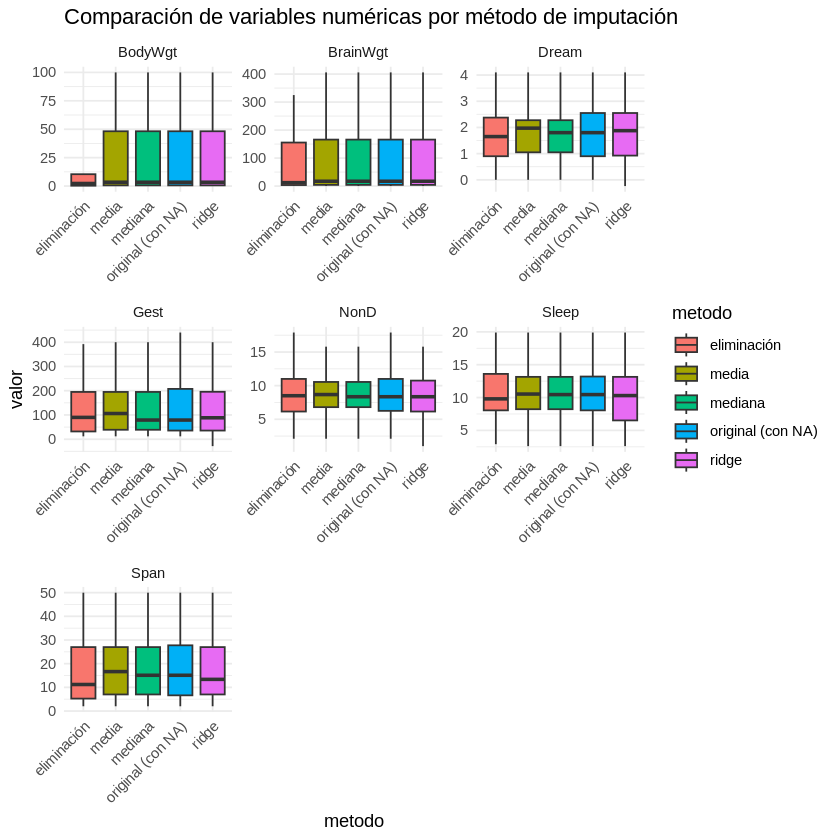

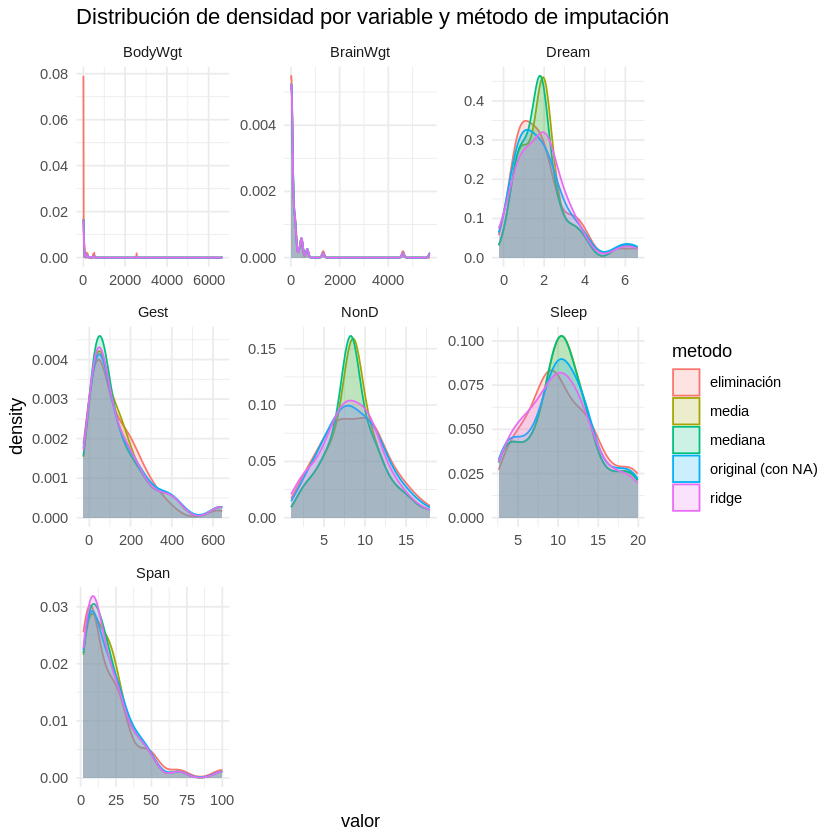

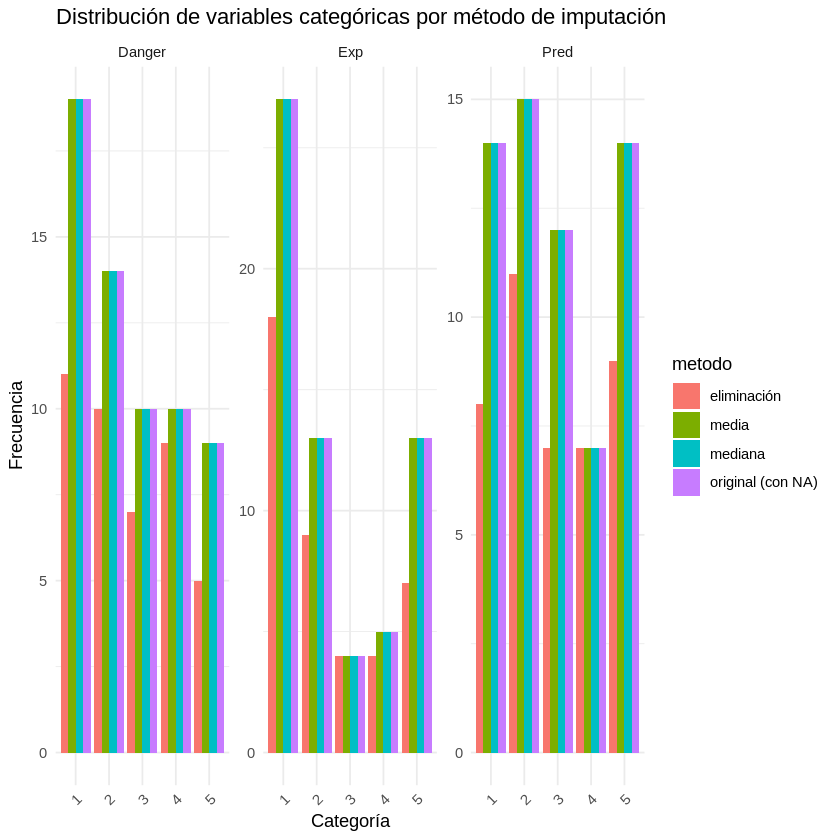

In [182]:
# Comparación de métodos de imputación sobre el dataset `sleep`

# ------------------- Cargar paquetes necesarios -------------------
library(VIM)         # Visualización y manipulación de datos faltantes
library(visdat)      # Exploración visual de estructuras y tipos de variables
library(dplyr)       # Manipulación de datos (select, filter, mutate, summarise, etc.)
library(tidyr)       # Transformaciones de datos (pivot_longer, pivot_wider, etc.)
library(ggplot2)     # Visualización gráfica de datos
library(empire)      # Imputación de datos faltantes (media, mediana, regresión penalizada)

# ------------------- Cargar dataset -------------------
sleep <- VIM::sleep  # Cargar el conjunto de datos 'sleep'

# Seleccionar solo las columnas numéricas para aplicar métodos de imputación numérica
sleep_numericas <- dplyr::select_if(sleep, is.numeric)

# Eliminar filas que tengan al menos un NA (eliminación de casos)
sleep_limpio <- sleep[complete.cases(sleep), ]

# Aplicar imputación por la media a columnas numéricas
new_sleep_mean <- empire::impute_mean(data = sleep_numericas)

# Aplicar imputación por la mediana a columnas numéricas
new_sleep_median <- empire::impute_median(data = sleep_numericas)

# Aplicar imputación por regresión lineal penalizada (ridge) a primeras 7 columnas numéricas
new_sleep_ridge <- empire::estimate_ridge(data = sleep[,1:7], diff = 10, ridge_alpha = 0)

# ------------------- Definir función para alinear datasets -------------------
# Esta función unifica el número de columnas y añade el nombre del método como etiqueta
alinear_datos <- function(df, nombre, columnas_ref) {
  if (is.list(df) && !is.null(df$new_data)) {
    df <- df$new_data  # Extraer los datos imputados si el objeto es una lista
  }
  faltantes <- setdiff(columnas_ref, colnames(df))  # Identificar columnas faltantes
  df[faltantes] <- NA  # Añadirlas con NA si faltan
  df <- df[, columnas_ref]  # Reordenar columnas según las de referencia
  df$metodo <- nombre       # Añadir columna que indica el método
  return(df)
}

# Definir las columnas de referencia (del dataset original)
columnas_ref <- colnames(sleep)

# Unir todos los datasets con imputaciones diferentes en un solo data frame
# bind_rows() concatena por filas

todos <- bind_rows(
  alinear_datos(sleep, "original (con NA)", columnas_ref),
  alinear_datos(sleep_limpio, "eliminación", columnas_ref),
  alinear_datos(new_sleep_mean$new_data, "media", columnas_ref),
  alinear_datos(new_sleep_median$new_data, "mediana", columnas_ref),
  alinear_datos(new_sleep_ridge$new_data, "ridge", columnas_ref)
)

# Convertir columnas categóricas en factores para asegurar que sean tratadas correctamente
categoricas <- c("Pred", "Exp", "Danger")
todos[categoricas] <- lapply(todos[categoricas], as.factor)

# Asegurar también que las variables categóricas del dataset original sean factores
sleep$Pred <- as.factor(sleep$Pred)
sleep$Exp <- as.factor(sleep$Exp)
sleep$Danger <- as.factor(sleep$Danger)

# ====================== ANÁLISIS NUMÉRICO ======================

# Calcular estadísticas descriptivas (media, sd, min, max) para variables numéricas agrupadas por método
# group_by() agrupa por el método de imputación
# summarise(across(...)) aplica múltiples funciones a columnas numéricas
resumen <- todos %>%
  group_by(metodo) %>%
  summarise(across(
    where(is.numeric),
    list(
      media = ~mean(., na.rm = TRUE),
      sd = ~sd(., na.rm = TRUE),
      min = ~if (all(is.na(.))) NA else min(., na.rm = TRUE),
      max = ~if (all(is.na(.))) NA else max(., na.rm = TRUE)
    ),
    .names = "{.col}_{.fn}"
  ), .groups = "drop")

# Mostrar resumen en consola
print(resumen)

# Convertir a formato largo para graficar comparaciones
# pivot_longer transforma de formato ancho a largo para graficar con ggplot
long <- todos %>%
  pivot_longer(cols = where(is.numeric), names_to = "variable", values_to = "valor")

# Visualización numérica: boxplots por variable y método
# geom_boxplot() permite comparar medianas y dispersión

ggplot(long, aes(x = metodo, y = valor, fill = metodo)) +
  geom_boxplot(outliers = FALSE) +
  facet_wrap(~variable, scales = "free") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Comparación de variables numéricas por método de imputación")

# Visualización numérica: curvas de densidad
# geom_density() muestra la forma de la distribución
long_filtrado <- long %>% filter(!is.na(valor))

ggplot(long_filtrado, aes(x = valor, color = metodo, fill = metodo)) +
  geom_density(alpha = 0.2) +
  facet_wrap(~variable, scales = "free") +
  theme_minimal() +
  labs(title = "Distribución de densidad por variable y método de imputación")

# ====================== ANÁLISIS CATEGÓRICO ======================

# Convertir datos categóricos a formato largo para graficar
# Se elimina 'ridge' porque no contiene variables categóricas
long_cat <- todos %>%
  filter(metodo != "ridge") %>%
  select(metodo, all_of(categoricas)) %>%
  pivot_longer(cols = -metodo, names_to = "variable", values_to = "valor")

# Gráfico de barras para variables categóricas
# geom_bar() con position = "dodge" compara frecuencias absolutas entre métodos

ggplot(long_cat, aes(x = valor, fill = metodo)) +
  geom_bar(position = "dodge") +
  facet_wrap(~variable, scales = "free") +
  theme_minimal() +
  labs(title = "Distribución de variables categóricas por método de imputación",
       x = "Categoría", y = "Frecuencia") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: RColorBrewer



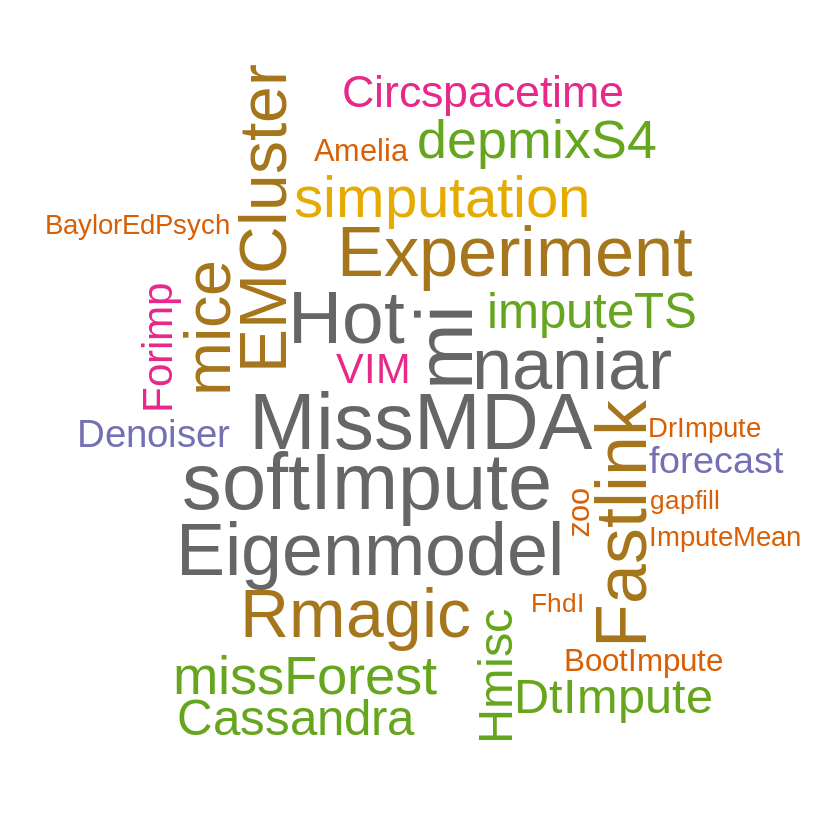

In [139]:
# @title crea mapa
install.packages("wordcloud")
install.packages("RColorBrewer")

library(wordcloud)
library(RColorBrewer)
paquetes <- c(
  "VIM", "naniar", "missForest", "Amelia", "mice", "Hmisc", "depmixS4",
  "imputeTS", "zoo", "forecast", "softImpute", "MissMDA", "EMCluster",
  "mi", "simputation", "BaylorEdPsych", "Rmagic", "Denoiser", "gapfill",
  "DtImpute", "DrImpute", "Hot", "Circspacetime", "Fastlink", "Eigenmodel",
  "Cassandra", "Experiment", "BootImpute", "Forimp", "FhdI", "ImputeMean"
)
set.seed(123)
frecuencias <- sample(10:100, length(paquetes), replace = TRUE)
wordcloud(
  words = paquetes,
  freq = frecuencias,
  min.freq = 1,
  scale = c(4, 0.8),             # Tamaño de fuente
  colors = brewer.pal(8, "Dark2"),
  random.order = FALSE,
  rot.per = 0.2,                 # Proporción de palabras giradas
  main = "Paquetes de R para datos faltantes"
)


